In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import shutil
import json
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys
sys.path.append('/home/lea/trampo/MODELS_2D3D/mmpose')

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.utils import adapt_mmdet_pipeline

from mmdet.apis import DetInferencer

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

from utils import predict_multiview_with_grad, find_best_triangulation, project_points

/home/lea/anaconda3/envs/vitpose_mmpose/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


### Setup dataset folder

In [2]:
root_dir = '/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429'
data_dir = '/home/lea/trampo/MODELS_2D3D/finetuning_multiview/dataset'

sequences = set([str(f).split('-')[0] for f in os.listdir(root_dir)])

sequences = sorted([seq for seq in sequences if seq[0] in ['1', '2']])

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141', 'Camera4_M11458',
           'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']

""" for seq in sequences:
    if not os.path.isdir(os.path.join(data_dir, seq)):
        os.makedirs(os.path.join(data_dir, seq))
    for cam in cameras:
        dest_dir = os.path.join(data_dir, seq, cam)
        source_dir = os.path.join(root_dir, seq+'-'+cam)
        shutil.copytree(source_dir, dest_dir) """

" for seq in sequences:\n    if not os.path.isdir(os.path.join(data_dir, seq)):\n        os.makedirs(os.path.join(data_dir, seq))\n    for cam in cameras:\n        dest_dir = os.path.join(data_dir, seq, cam)\n        source_dir = os.path.join(root_dir, seq+'-'+cam)\n        shutil.copytree(source_dir, dest_dir) "

In [3]:
class MultiViewDataset(Dataset):
    def __init__(self, root_dir, K, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Discover all sequences
        sequences = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.sequences = sorted(sequences)
        
        self.sequence_data = []  # Will hold (seq_name, frame_names, calibration)
        self.index_map = []      # Global index -> (seq_idx, frame_idx)

        for seq_idx, seq_name in enumerate(self.sequences):
            seq_path = os.path.join(root_dir, seq_name)

            # Load calibration for this sequence
            session = seq_name.split('-')[0].split('_')[2]
            calib_path = os.path.join('calib', f'WorldTCam_{session}.npz')

            world_T_cam = np.load(calib_path)['arr_0']
            projMat = np.stack([np.linalg.inv(mat) for mat in world_T_cam])

            Ts = torch.tensor(projMat, dtype=torch.float32)
            Ks = torch.tensor(K, dtype=torch.float32)

            # Get camera dirs
            cam_dirs = sorted([d for d in os.listdir(seq_path) if d.startswith("Cam")])
            cam_dirs = [os.path.join(seq_path, d) for d in cam_dirs]
            self.cam_dirs = cam_dirs

            # Get frames from first camera (assume sync)
            frame_names = sorted(os.listdir(cam_dirs[0]))

            # Store metadata for this sequence
            self.sequence_data.append({
                "name": seq_name,
                "cam_dirs": cam_dirs,
                "frame_names": frame_names,
                "Ks": Ks,
                "Ts": Ts
            })

            # Build global index mapping
            for frame_idx in range(len(frame_names)):
                self.index_map.append((seq_idx, frame_idx))

        self.num_views = len(self.cam_dirs)

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        seq_idx, frame_idx = self.index_map[idx]
        seq_info = self.sequence_data[seq_idx]

        Ks, Ts = seq_info["Ks"], seq_info["Ts"]
        frame_name = seq_info["frame_names"][frame_idx]

        images = []
        for cam_dir in seq_info["cam_dirs"]:
            img_path = os.path.join(cam_dir, frame_name)
            img = cv2.imread(img_path)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transform:
                img = self.transform(image=img)['image']
            else:
                img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
            images.append(img)

        images = torch.stack(images, dim=0)  # (V,C,H,W)

        return {
            "images": images,  # (V,C,H,W)
            "Ks": Ks,
            "Ts": Ts,
            "seq_name": seq_info["name"],
            "frame_idx": frame_idx
        }
    
K = np.load('calib/K.npz')['arr_0']
D = np.load('calib/D.npz')['arr_0']

# Dataloader
dataset = MultiViewDataset(root_dir=data_dir, K=K, transform=None)

print(len(dataset))  # total number of frames across all sequences

sample = dataset[0]
print(sample.keys())
print(sample["images"].shape)  # (V, C, H, W)
print(sample["Ks"].shape)      # (V, 3, 3)
print(sample["seq_name"], sample["frame_idx"])

2645
dict_keys(['images', 'Ks', 'Ts', 'seq_name', 'frame_idx'])
torch.Size([8, 3, 1080, 1920])
torch.Size([8, 3, 3])
1_partie_0429 0


### Train

In [4]:
# Set training parameters
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda:0' # FOR TESTING
LEARNING_RATE = 1e-5
BATCH_SIZE = 2

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

# Init detector
det_config = '/home/lea/trampo/MODELS_2D3D/mmpose/demo/mmdetection_cfg/rtmdet_m_640-8xb32_coco-person.py'
det_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth'
#det_config = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmdet_nano_320-8xb32_coco-person.py" 
#det_checkpoint = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth"
det_model= init_detector(det_config, det_checkpoint, device=device)
det_model.cfg = adapt_mmdet_pipeline(det_model.cfg)


# Init pose model
pose_config = '/home/lea/trampo/MODELS_2D3D/mmpose/configs/body_2d_keypoint/rtmpose/body8/rtmpose-m_8xb256-420e_body8-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth'
#pose_config = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmpose-l_8xb256-420e_coco-256x192.py"  
#pose_checkpoint = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmpose-l_simcc-aic-coco_pt-aic-coco_420e-256x192-f016ffe0_20230126.pth"
pose_model = init_pose_estimator(pose_config, pose_checkpoint, device=device)
pose_model.train()

# Unfreeze all parameters
for param in pose_model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(pose_model.parameters(), lr=LEARNING_RATE)

/home/lea/anaconda3/envs/vitpose_mmpose/lib/python3.10/importlib/__init__.py:169: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  _bootstrap._exec(spec, module)


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth


In [5]:
%load_ext autoreload
%autoreload 2
from utils import predict_multiview_with_grad, find_best_triangulation, project_points


In [ ]:
error_thresh = 50
torch.set_printoptions(precision=4, sci_mode=False)

for multi_view_batch in dataloader:  # custom dataloader yielding (B,V,C,H,W)
    images, Ks, Ts, seq, frames = multi_view_batch.values()  # camera intrinsics, extrinsics, R Pose2Sim -> world
    images = images.to(device)
    Ks = Ks.to(device)
    Ts = Ts.to(device)
    
    optimizer.zero_grad()

    keypoints = predict_multiview_with_grad(det_model, pose_model, images, bbox_thr=0.3, pose_batch_size=16, training=False)

    #for b in range(keypoints.shape[0]):
    #    print(keypoints[b, 0, 0])

    # Triangulate (batched)
    error, preds, points_3d = find_best_triangulation(keypoints, Ks, Ts, error_thresh)  # (B,K,3)

    print(points_3d)
    # error correspond to reprojection error of best triangulation only on good views

    if torch.isnan(points_3d).all():
        continue
    
    Rt = Ts[:, :, :3, :]
    P_all = (Ks @ Rt).squeeze()
    reproj, _ = project_points(points_3d, P_all)  # (V,B,K,2)

    mask = (preds != 0).any(dim=-1) & (reproj != 0).any(dim=-1)  # (N_cams, K)
    mask = mask.unsqueeze(-1)  # (N_cams, K, 1) so it can broadcast with coords

    # Apply mask
    preds_valid = preds[mask.expand_as(preds)].view(-1, 2)
    reproj_valid = reproj[mask.expand_as(reproj)].view(-1, 2)

    # Compute RMSE only on valid entries
    loss = torch.sqrt(torch.nn.functional.mse_loss(preds_valid, reproj_valid))

    print(error, loss)
    
    # loss correspond to reprojection error of best triangulation on ALL views
    loss.backward()
    optimizer.step()

    

/home/lea/anaconda3/envs/vitpose_mmpose/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[ 127.5583,   80.0910, 3836.8970],
         [ 118.2878,   58.8158, 3816.9309],
         [ 150.4355,   31.7059, 3812.4348],
         [ 106.2743,   57.2974, 3816.1941],
         [ 171.4273,   44.1915, 3815.9463],
         [  99.6274,   66.6486, 3970.2991],
         [ 212.6327,   81.3646, 3927.6421],
         [ 100.3530,  116.4382, 4224.6724],
         [ 330.3631,  146.2021, 4163.8457],
         [  99.7310,  204.0264, 4440.6426],
         [ 356.0473,  193.7586, 4372.6372],
         [ 194.9586,  125.9712, 4401.1255],
         [ 270.0905,  145.9760, 4387.0605],
         [ 301.7872,  128.8010, 4768.8477],
         [ 357.2495,  133.9702, 4757.8154],
         [ 420.4611,  -11.3639, 5068.2607],
         [ 442.1431,   34.6966, 5084.6431]],

        [[-785.0784, -296.5897, 2831.3552],
         [-812.8883, -302.5780, 2823.5583],
         [-810.0250, -299.9691, 2814.1855],
         [-838.2202, -395.5490, 2886.7476],
         [-858.9140, -297.6300, 2881.3516],
         [-794.6356, -414.2704

### Show keypoints on images

(8, 3, 1080, 1920) (2, 8, 17, 2) (2, 8, 17, 2)


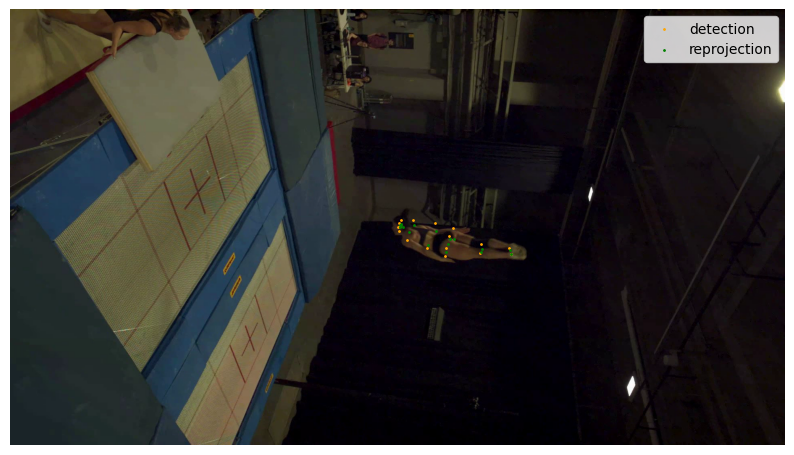

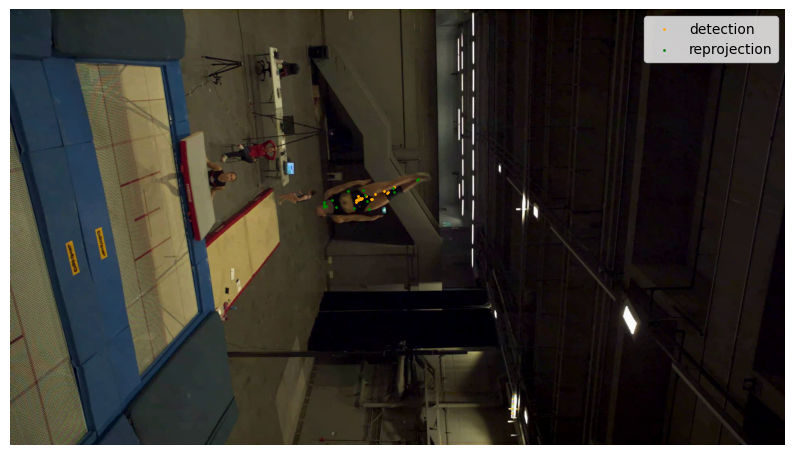

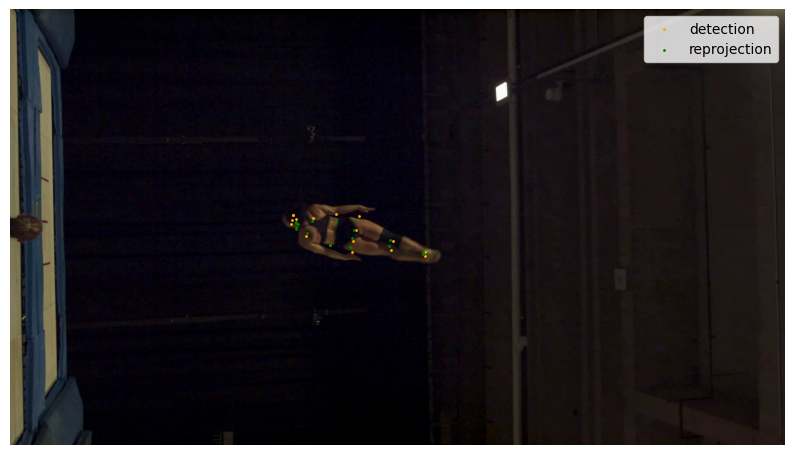

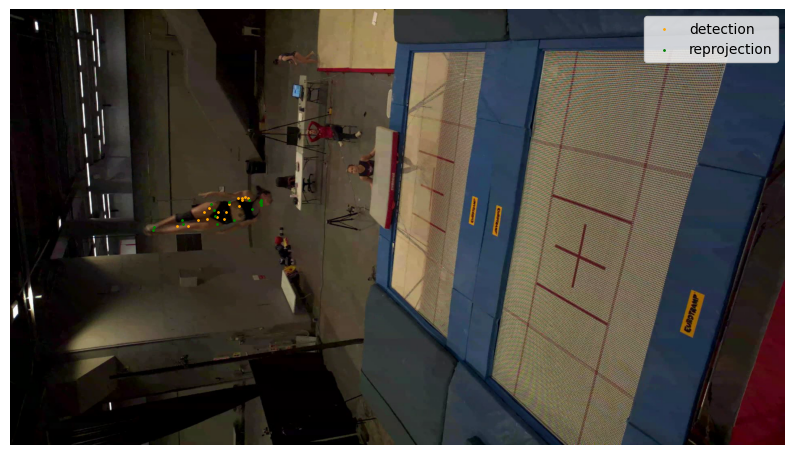

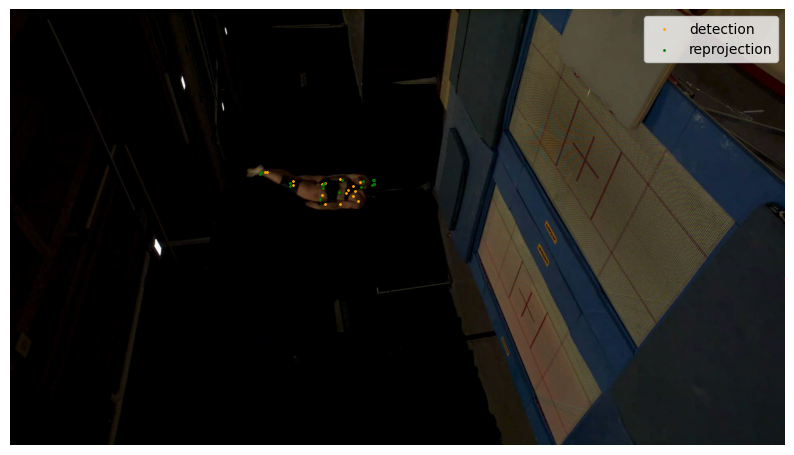

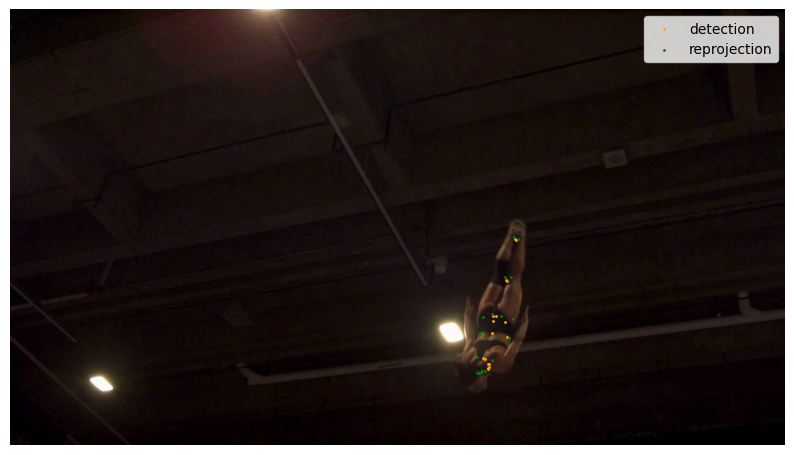

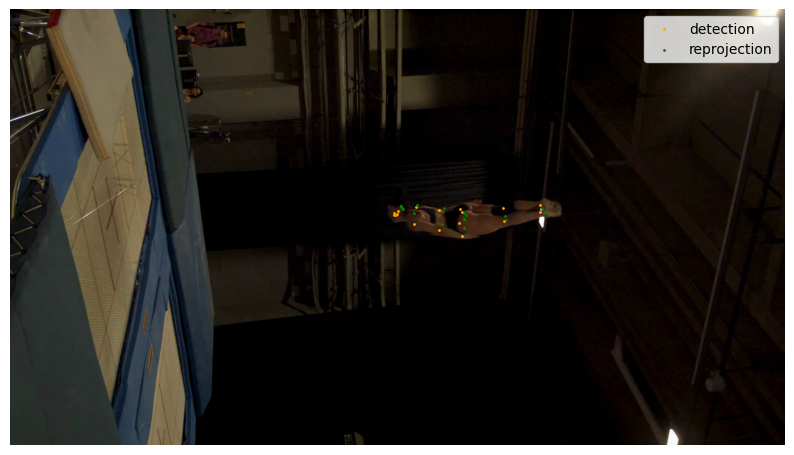

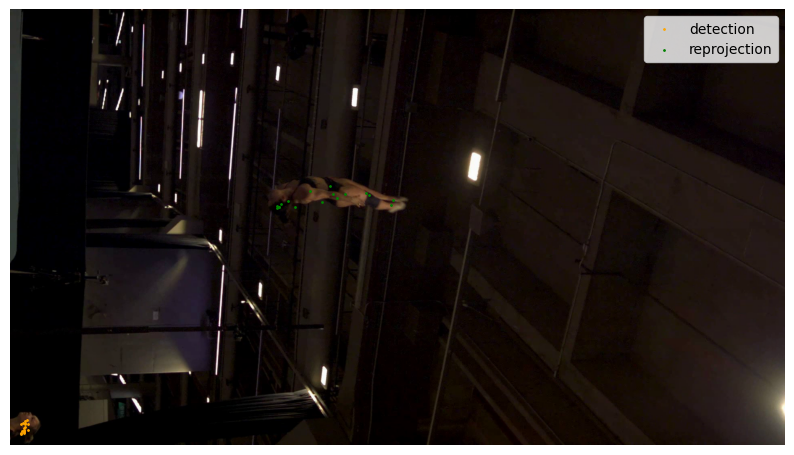

In [7]:
images_np = images.cpu().detach().numpy()[0]
pts_d = preds.cpu().detach().numpy()
pts_r = reproj.cpu().detach().numpy()

print(images_np.shape, pts_d.shape, pts_r.shape)
for im, pt_d, pt_r in zip(images_np, pts_d[0], pts_r[0]):
    im = np.transpose(im, axes=(1,2,0))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(im)
    
    plt.scatter(*pt_d.T, s=1, color='orange', label='detection')
    plt.scatter(*pt_r.T, s=1, color='green', label='reprojection')

    plt.legend()
    plt.axis('off')
    plt.show()

## Test detectors

In [8]:
import cv2
import matplotlib.patches as patches

def plot_bbox_on_image(image, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(image)  # show image
    for bbox in bboxes:
        x, y = bbox[0], bbox[1]
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height,
            linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [9]:
model = YOLO("yolo11l.pt")

path = '/home/lea/trampo/MODELS_2D3D/finetuning_multiview/dataset/1_partie_0429_003/Camera2_M11140'
im_files = os.listdir(path)

det = 0
for i, im_file in tqdm(enumerate(im_files)):
    im_name = os.path.join(path, im_file)
    results = model(im_name, classes=[0], conf=0.3, verbose=False)
    bboxes = results[0].boxes.xyxy
    det += len(bboxes)

    if i % 100 == 0:
        plot_bbox_on_image(cv2.imread(im_name), bboxes.cpu().numpy())
    """ 
    if len(bboxes) > 0:
        print(bboxes)

    for result in results:  # peut contenir plusieurs images
        boxes = result.boxes  # toutes les bbox
        for box in boxes:
            cls = int(box.cls[0])          # classe prédite (0 = person dans COCO)
            conf = float(box.conf[0])      # score de confiance
            xyxy = box.xyxy[0].tolist()    # coordonnées [x1, y1, x2, y2] """  

print(det)

NameError: name 'YOLO' is not defined

## Versions

In [ ]:
import mmdet, mmpose, mmengine
print("MMDetection:", mmdet.__version__)
print("MMPose:", mmpose.__version__)
print("MMEngine:", mmengine.__version__)

#print(type(img_np), img_np.shape if hasattr(img_np, "shape") else None)
print(det_model.__class__)
print(det_model.cfg.test_dataloader.dataset.pipeline)